In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp '/content/gdrive/MyDrive/Coordinate/aio_2022_ta/speech_recognition/dataset/warblrb10k_public_metadata.csv' .
!cp '/content/gdrive/MyDrive/Coordinate/aio_2022_ta/speech_recognition/dataset/warblrb10k_public_wav.zip' .
!unzip 'warblrb10k_public_wav.zip'

Streaming output truncated to the last 5000 lines.
  inflating: wav/60664464-7386-4a7e-b6bc.wav  
  inflating: wav/6066f2d8-83bd-4fe0-9524.wav  
  inflating: wav/607b922c-72b1-4713-bb15.wav  
  inflating: wav/6080b97a-cdfa-4e53-b361.wav  
  inflating: wav/60877c20-6065-4040-8860.wav  
  inflating: wav/60964db5-53b9-4b94-973e.wav  
  inflating: wav/60a0306e-b1eb-467e-a016.wav  
  inflating: wav/60a15272-9c9c-48b0-916d.wav  
  inflating: wav/60a95b52-c245-4509-b17f.wav  
  inflating: wav/60ae2dc9-c44c-4093-a4cf.wav  
  inflating: wav/60c77255-4844-41b3-ab8e.wav  
  inflating: wav/60d46b89-3c2b-4b85-a440.wav  
  inflating: wav/60dd82db-792b-4c99-a9be.wav  
  inflating: wav/60de9722-76fa-41a1-a123.wav  
  inflating: wav/60e061dd-899e-494c-946e.wav  
  inflating: wav/60efc23a-9095-47e1-9b1c.wav  
  inflating: wav/6100d61b-04d8-4d8a-9ac5.wav  
  inflating: wav/610e115b-bd36-4f11-bb8c.wav  
  inflating: wav/611a0289-c394-4fcd-ac04.wav  
  inflating: wav/611b4621-dc8c-44cb-b597.wav  
  inflati

In [3]:
!pip install tensorflow_io -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 14.8 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import tensorflow_io as tfio

from IPython import display

RANDOM_SEED = 59
tf.random.set_seed(RANDOM_SEED) 

In [5]:
frame_length = 256
frame_step = 160
fft_length = 384
input_dim = fft_length // 2 + 1
max_duration = 25
target_sr = 16000

def audio_preprocessing_librosa(audio_path):
    audio, sr = librosa.load(audio_path, sr=target_sr)
    audio = librosa.util.fix_length(audio, 
        size=int(sr * max_duration)
    )
    audio = audio.astype(np.float32) 
    stfts = librosa.stft(
        audio,
        n_fft=fft_length,
        hop_length=frame_step,
        win_length=frame_length,
    )

    spectrogram = np.abs(stfts)
    spectrogram = librosa.amplitude_to_db(spectrogram)

    means = np.mean(spectrogram, axis=1, keepdims=True)
    stddevs = np.std(spectrogram, axis=1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    spectrogram = spectrogram.T

    return spectrogram


def audio_preprocessing_tf(audio_path):
    audio_file = tf.io.read_file(audio_path)
    audio, sr = tf.audio.decode_wav(
        audio_file,
        desired_samples=int(max_duration * target_sr)
    )

    audio = tf.cast(audio, tf.float32) 
    audio = tf.squeeze(audio, axis=-1)

    stfts = tf.signal.stft(
        audio, 
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )

    spectrogram = tf.math.abs(stfts) 
    spectrogram = tfio.audio.dbscale(spectrogram, top_db=80)

    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    return spectrogram

def one_hot_encoding(label, n_classes=2):
    vector_one_hot = tf.one_hot(label, n_classes)

    return vector_one_hot

In [6]:
AUDIO_DIR = './wav'
LABEL_PATH = './warblrb10k_public_metadata.csv'

label_df = pd.read_csv(LABEL_PATH)
n_samples = label_df.shape[0]
label_df['itemid'] = label_df['itemid'].apply(lambda x: os.path.join(AUDIO_DIR, x + '.wav'))
audio_paths = label_df['itemid'].values[:n_samples//4]
labels = label_df['hasbird'].values[:n_samples//4]
label_df

,itemid,hasbird
0,./wav/759808e5-f824-401e-9058.wav,1
1,./wav/1d94fc4a-1c63-4da0-9cac.wav,1
2,./wav/bb0099ce-3073-4613-8557.wav,1
3,./wav/c4c67e81-9aa8-4af4-8eb7.wav,1
4,./wav/ab322d4b-da69-4b06-a065.wav,0
...,...,...
7995,./wav/ca7b3342-17b0-444f-ba2a.wav,1
7996,./wav/43071f95-d31e-447b-8786.wav,1
7997,./wav/0d4d2fea-743d-46aa-a17f.wav,1
7998,./wav/0d34160d-55db-4c70-93fa.wav,1


## Usecase 1: Using librosa 

In [ ]:
BATCH_SIZE = 128

audio_arrs = []
label_arrs = []
for idx in range(len(audio_paths)):
    spectrogram = audio_preprocessing_librosa(audio_paths[idx])
    label_arr = one_hot_encoding(labels[idx])

    audio_arrs.append(spectrogram)
    label_arrs.append(label_arr)

audio_arrs = np.array(audio_arrs)
label_arrs = np.array(label_arrs)

TRAIN_SIZE = 0.7
train_n_samples = int(TRAIN_SIZE * len(audio_arrs))

train_audio_arrs = audio_arrs[:train_n_samples]
train_label_arrs = label_arrs[:train_n_samples]

val_audio_arrs = audio_arrs[train_n_samples:]
val_label_arrs = label_arrs[train_n_samples:]

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_audio_arrs, train_label_arrs)
).shuffle(train_n_samples//2).cache().prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_audio_arrs, val_label_arrs)
).cache().prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

## Usecase 2: Using tensorflow

In [7]:
BATCH_SIZE = 128
TRAIN_SIZE = 0.7
train_n_samples = int(TRAIN_SIZE * len(audio_paths))

train_audio_paths = audio_paths[:train_n_samples]
train_labels = labels[:train_n_samples]

val_audio_paths = audio_paths[train_n_samples:]
val_labels = labels[train_n_samples:]

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_audio_paths, train_labels)
)
train_ds = train_ds.map(
    lambda x, y: (audio_preprocessing_tf(x), one_hot_encoding(y)), num_parallel_calls=tf.data.AUTOTUNE
).shuffle(train_n_samples//2).cache().prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_audio_paths, val_labels)
)
val_ds = val_ds.map(
    lambda x, y: (audio_preprocessing_tf(x), one_hot_encoding(y)), num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

In [ ]:
val_ds.element_spec

(TensorSpec(shape=(None, 2499, 193), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

In [ ]:
# for arr in audio_arrs:
#     print(arr.shape)

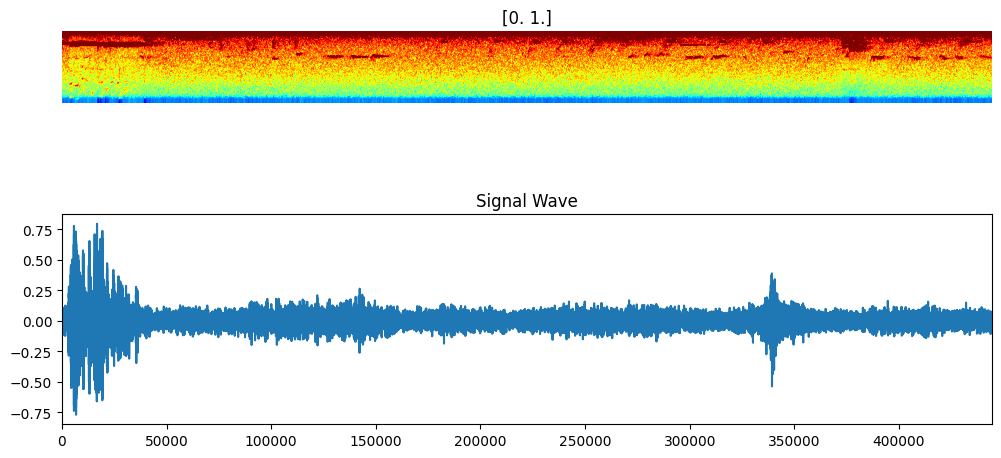

In [ ]:
fig = plt.figure(figsize=(12, 6))
for batch in train_ds.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0].numpy()
    # Spectrogram
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1, cmap='jet')
    ax.set_title(str(label))
    ax.axis("off")
    # Wav
    file = tf.io.read_file(audio_paths[0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [8]:
n_rnn_layers = 1
input_layer = tf.keras.layers.Input(
    (None, input_dim), 
    dtype=tf.float32, 
    name='input_layer'
)
x = tf.keras.layers.Reshape(
    (-1, input_dim, 1),
    name='expand_dim_layer'
)(input_layer)
x = tf.keras.layers.Conv2D(
    32,
    kernel_size=3,
    strides=2,
    activation='relu',
    name='conv_1'
)(x)
x = tf.keras.layers.BatchNormalization(
    name='conv_1_bn'
)(x)
x = tf.keras.layers.Conv2D(
    32,
    kernel_size=3,
    strides=2,
    activation='relu',
    name='conv_2'
)(x)
x = tf.keras.layers.BatchNormalization(
    name='conv_2_bn'
)(x)
x = tf.keras.layers.Reshape(
    (-1, x.shape[-1] * x.shape[-2]),
    name='squeeze_layer'
)(x)
for idx in range(n_rnn_layers):
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            32,
            return_sequences=True
        ), 
        name=f'bilstm_{idx}'
    )(x) 

    if idx == n_rnn_layers - 1:
        x = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                32,
                return_sequences=False
            ),
            name=f'bilstm_{idx+1}'
        )(x) 
        x = tf.keras.layers.Dropout(
            0.2, 
            name='dropout_01'
        )(x)
x = tf.keras.layers.Dense(
    64, 
    activation='relu',
    name="dense_1"
)(x)
x = tf.keras.layers.Dropout(
    0.3, 
    name='dropout_dense_01'
)(x)
output_layer = tf.keras.layers.Dense(
    2,
    activation='softmax',
    name='output_layer'
)(x)

model = tf.keras.Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, None, 193)]       0         
                                                                 
 expand_dim_layer (Reshape)  (None, None, 193, 1)      0         
                                                                 
 conv_1 (Conv2D)             (None, None, 96, 32)      320       
                                                                 
 conv_1_bn (BatchNormalizati  (None, None, 96, 32)     128       
 on)                                                             
                                                                 
 conv_2 (Conv2D)             (None, None, 47, 32)      9248      
                                                                 
 conv_2_bn (BatchNormalizati  (None, None, 47, 32)     128       
 on)                                                         

In [9]:
EPOCHS = 10

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/10
11/11 [==============================] - 389s 20s/step - loss: 0.5507 - accuracy: 0.7586 - val_loss: 0.5586 - val_accuracy: 0.7550
Epoch 2/10
11/11 [==============================] - 9s 821ms/step - loss: 0.4835 - accuracy: 0.7729 - val_loss: 0.5346 - val_accuracy: 0.7533
Epoch 3/10
11/11 [==============================] - 9s 790ms/step - loss: 0.4616 - accuracy: 0.7993 - val_loss: 0.5544 - val_accuracy: 0.7700
Epoch 4/10
11/11 [==============================] - 9s 813ms/step - loss: 0.4230 - accuracy: 0.8050 - val_loss: 0.5017 - val_accuracy: 0.7550
Epoch 5/10
11/11 [==============================] - 9s 799ms/step - loss: 0.3674 - accuracy: 0.8336 - val_loss: 0.5024 - val_accuracy: 0.7733
Epoch 6/10
11/11 [==============================] - 9s 789ms/step - loss: 0.3195 - accuracy: 0.8657 - val_loss: 0.5173 - val_accuracy: 0.7833
Epoch 7/10
11/11 [==============================] - 9s 797ms/step - loss: 0.2235 - accuracy: 0.9150 - val_loss: 0.4948 - val_accuracy: 0.7783
Epoch 

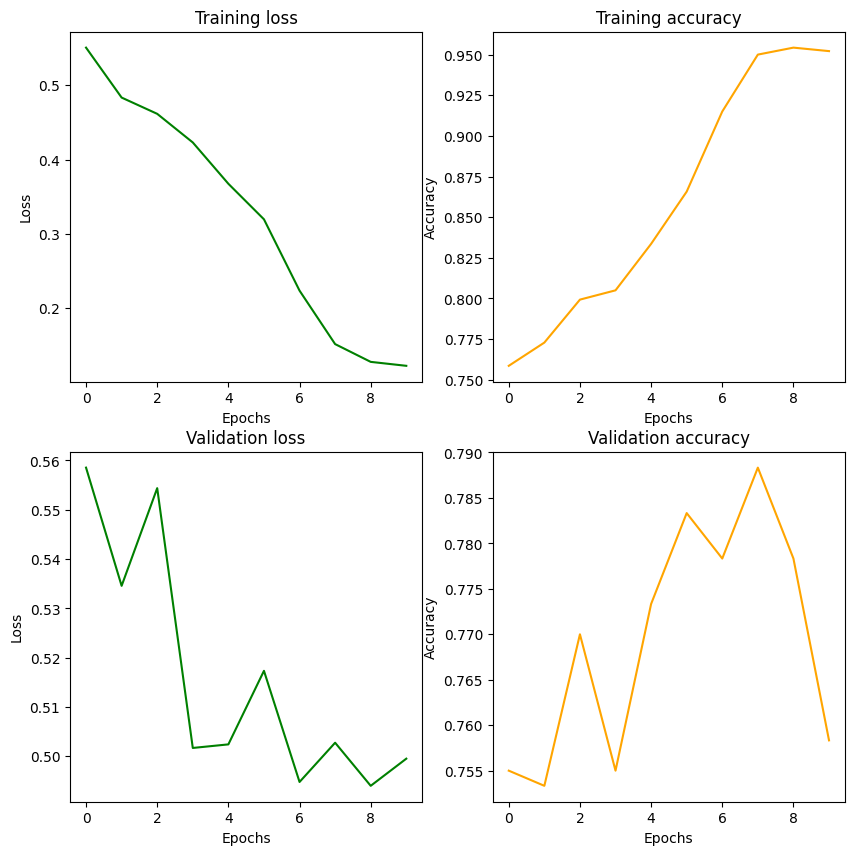

In [10]:
train_loss, train_acc = history.history['loss'], history.history['accuracy'] 
val_loss, val_acc = history.history['val_loss'], history.history['val_accuracy'] 

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1) 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.title('Training loss') 
plt.plot(train_loss, color='green') 

plt.subplot(2, 2, 2) 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy')
plt.plot(train_acc, color='orange') 

plt.subplot(2, 2, 3)
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.title('Validation loss') 
plt.plot(val_loss, color='green') 

plt.subplot(2, 2, 4) 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.title('Validation accuracy')
plt.plot(val_acc, color='orange') 
plt.show() 